In [1]:
# Import math and CV libs
from lesson_functions import *
import numpy as np
import cv2

In [2]:
# Import Visualization and video handling tools
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [3]:
# Import Scikit Modules
from sklearn.svm import LinearSVC
from skimage.feature import hog
from scipy.ndimage.measurements import label
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [4]:
# Enable inline Plotting
%matplotlib inline

In [5]:
# Load all file names into lists
import glob
cars = glob.glob('training/vehicles/**/*.png')
noncars = glob.glob('training/non-vehicles/**/*.png')

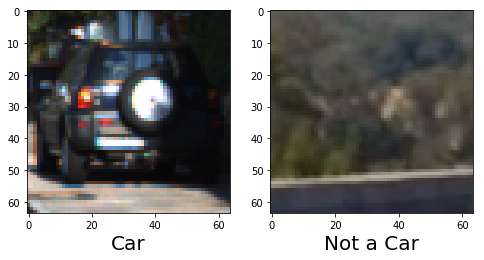

In [6]:
# Check whether Cars file names have been loaded properly
rand_car_ind = np.random.randint(0,len(cars) - 1)
rand_car_img = cv2.imread(cars[rand_car_ind])
rand_car_img = cv2.cvtColor(rand_car_img,cv2.COLOR_BGR2RGB)
plt.figure(figsize=(8,8))
plt.subplot(121)
plt.imshow(rand_car_img,cmap='gray')
plt.xlabel('Car',fontsize=20)

plt.subplot(122)
# Check whether Non-Car file names have been loaded properly
rand_nc_ind = np.random.randint(0,len(noncars) - 1)
rand_nc_img = cv2.imread(noncars[rand_nc_ind])
rand_nc_img = cv2.cvtColor(rand_nc_img,cv2.COLOR_BGR2RGB)
plt.imshow(rand_nc_img,cmap='gray')
plt.xlabel('Not a Car',fontsize=20)

In [7]:
# Function to Convert image to desired color space
def convert_image(image,cspace):
    '''''
    Param: input image in RGB format
    Param: Desired image colorspace
    Returns: image in desired colorspace
    '''''
    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(image)      
    return feature_image

In [8]:
# Class for feature Extraction
# A Class based approach for feature extraction is used for the purposes of code reusability
class Feature_extractor:
    color_space='RGB'
    spatial_size=(32, 32)
    hist_bins=8
    orient=9
    pix_per_cell=8
    cell_per_block=2
    hog_channel=0
    spatial_feat=True
    hist_feat=True
    hog_feat=True
    X_scaler = None
    
    # Constructor
    def __init__(self, color_space='RGB', spatial_size=(32, 32),
                 hist_bins=8, orient=9, 
                 pix_per_cell=8, cell_per_block=2, hog_channel=0,
                 spatial_feat=True, hist_feat=True, hog_feat=True, X_scaler = None):
        self.color_space = color_space
        self.hist_bins = hist_bins
        self.spatial_size = spatial_size
        self.orient = orient
        self.pix_per_cell = pix_per_cell
        self.cell_per_block = cell_per_block
        self.hog_channel = hog_channel
        self.spatial_feat = spatial_feat
        self.hist_feat = hist_feat
        self.hog_feat = hog_feat
        self.X_scaler = X_scaler
        
    # Method to return image features    
    def extract_features(self, img):
        feature_families = 0
        #1) Define an empty list to receive features
        img_features = []

        # Apply Color Conversion
        feature_image = convert_image(img,self.color_space)
        
        # normalize the image
        feature_image = feature_image/255

        # Compute spatial features
        if self.spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=self.spatial_size)
            #4) Append features to list
            img_features.append(np.float64(spatial_features))
            feature_families += 1

        # Compute histogram features 
        if self.hist_feat == True:
            hist_features = color_hist(feature_image, nbins=self.hist_bins)
            #6) Append features to list
            img_features.append(np.float64(hist_features))
            feature_families += 1

        # Compute HOG features
        if self.hog_feat == True:
            hog_features_list = []
            for i in range(3):
                channel_img = img[:,:,i]
        
                ch_hog_features = get_hog_features(img=channel_img,
                                                orient= self.orient,
                                                pix_per_cell= self.pix_per_cell, 
                                                cell_per_block = self.cell_per_block)
                hog_features_list.append(ch_hog_features)
            hog_features = np.hstack(hog_features_list)
            
            img_features.append(np.float64(hog_features))
            feature_families += 1
            
        # Concatenate the Features
        concat_img_features = np.concatenate(img_features).astype(np.float64)
        
        # if X scaler has been set and more than one feature family is active
        # Fit the extracted features using a X scaler
        if(self.X_scaler != None) and (feature_families > 1):
            concat_img_features = X_scaler.transform(concat_img_features)
        
        # Return features
        return concat_img_features
    
    def multi_img_features(self, img_list):
        
        # Create a list to append feature vectors to
        features = []

        # Iterate through the list of images
        for file in img_list:
            # Read in each one by one
            image = mpimg.imread(file)
            # Extract features as per feature extractor configuration
            img_features = self.extract_features(image)
            # append 
            features.append(img_features)

        # Return list of feature vectors
        return features


In [9]:
# check Individual features by visualization
spatial_extractor = Feature_extractor(color_space='HLS',
                              spatial_size=(16, 16),
                              hist_bins=8,
                              orient=9, 
                              pix_per_cell=8,
                              cell_per_block=2,
                              hog_channel=0,
                              spatial_feat=True,
                              hist_feat=False,
                              hog_feat=False)

car_img = rand_car_img
car_spatial_features = spatial_extractor.extract_features(car_img)

non_car_img = rand_nc_img
nc_spatial_features = spatial_extractor.extract_features(non_car_img)


768


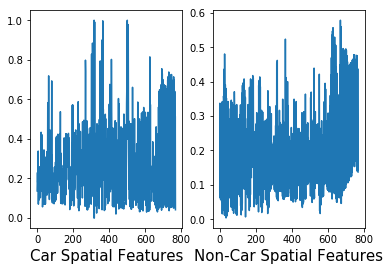

In [10]:
plt.figure()
plt.subplot(121)
plt.plot((car_spatial_features))
plt.xlabel("Car Spatial Features",fontsize=15)

plt.subplot(122)
plt.plot(nc_spatial_features)
plt.xlabel("Non-Car Spatial Features",fontsize=15)

print (len(car_spatial_features))

In [11]:
hist_extractor = Feature_extractor(color_space='YUV',
                              spatial_size=(32, 32),
                              hist_bins=16,
                              orient=9, 
                              pix_per_cell=8,
                              cell_per_block=2,
                              hog_channel=0,
                              spatial_feat=False,
                              hist_feat=True,
                              hog_feat=False)

car_hist_features = hist_extractor.extract_features(car_img)

nc_hist_features = hist_extractor.extract_features(non_car_img)

48


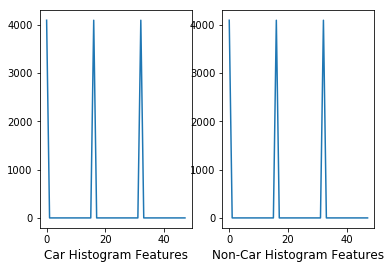

In [12]:
plt.figure()
plt.subplot(121)
plt.plot(car_hist_features)
plt.xlabel("Car Histogram Features",fontsize=12)

plt.subplot(122)
plt.plot(nc_hist_features)
plt.xlabel("Non-Car Histogram Features",fontsize=12)

print (len(car_hist_features))

In [13]:
hog_extractor = Feature_extractor(color_space='YUV',
                              spatial_size=(32, 32),
                              hist_bins=16,
                              orient=11, 
                              pix_per_cell=16,
                              cell_per_block=2,
                              hog_channel=0,
                              spatial_feat=False,
                              hist_feat=False,
                              hog_feat=True)

car_hog_features = hog_extractor.extract_features(car_img)

nc_hog_features = hog_extractor.extract_features(non_car_img)

1188


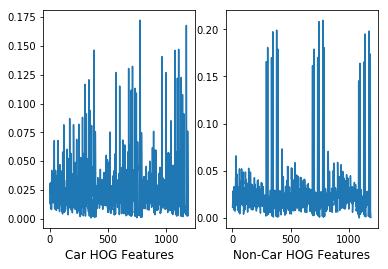

In [14]:
plt.figure()
plt.subplot(121)
plt.plot(car_hog_features)
plt.xlabel("Car HOG Features",fontsize=12)

plt.subplot(122)
plt.plot(nc_hog_features)
plt.xlabel("Non-Car HOG Features",fontsize=12)

print (len(car_hog_features))

In [15]:
combined_extractor = Feature_extractor(color_space='YUV',
                              spatial_size=(16, 16),
                              hist_bins=16,
                              orient=11, 
                              pix_per_cell=16,
                              cell_per_block=2,
                              hog_channel=0,
                              spatial_feat=True,
                              hist_feat=False,
                              hog_feat=True)
car_features = combined_extractor.extract_features(car_img)

nc_features = combined_extractor.extract_features(non_car_img)

1956


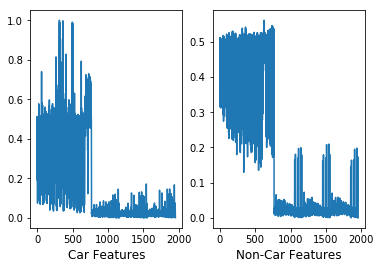

In [16]:
plt.figure()
plt.subplot(121)
plt.plot(car_features)
plt.xlabel("Car Features",fontsize=12)

plt.subplot(122)
plt.plot(nc_features)
plt.xlabel("Non-Car Features",fontsize=12)

print (len(car_features))

In [17]:
all_cars_features = combined_extractor.multi_img_features(cars)
all_nc_features = combined_extractor.multi_img_features(noncars)

X = np.vstack((all_cars_features, all_nc_features)).astype(np.float64) 

In [18]:
# Prepare a scaler to correct data scale
X_scaler = StandardScaler().fit(X)
# Scale data
scaled_X = X_scaler.transform(X)
#Create a Labels vector
y = np.hstack((np.ones(len(all_cars_features)),
               np.zeros(len(all_nc_features))))

In [19]:
# Prepare training and test sets
X_train, X_test, y_train, y_test = train_test_split(scaled_X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=np.random.randint(0,1000))

print('Feature vector length:', len(X_train[0]))

Feature vector length: 1956


In [20]:
# Create a SVC
svc = LinearSVC(C=0.001)

svc.fit(X_train, y_train)

# Check SVC Accuracy
print(' Accuracy: ', round(svc.score(X_test, y_test), 4))

n_predict = 10
print('Predix: ', svc.predict(X_test[0:n_predict]))
print('Labels: ', y_test[0:n_predict])


 Accuracy:  0.9794
Predix:  [ 0.  1.  0.  1.  1.  0.  1.  0.  1.  1.]
Labels:  [ 0.  1.  0.  1.  1.  0.  1.  0.  1.  1.]


In [21]:
# Class to find cars in input image
# A Class based approach for feature extraction is used for the purposes of code reusability
class Car_finder:
    
    feature_finder = None
    classifier = None
    x_size = 64
    y_size = 64
    windows = [[[0,0],[63,63]]]
    overlap = 0.6
    threshold = 1
    # Constructor
    def __init__(self, feature_finder, classifier):
        self.feature_finder = feature_finder
        self.classifier = classifier
        
    
    def create_search_windows(self,
                              img,
                              x_start_stop = [None,None],
                              y_start_stop = [None,None],
                              xy_overlap = (0.5,0.5),
                              xy_window = (64,64)):
    
        window_list = []
        imgsize = img.shape

        if (x_start_stop == [None,None]):
            x_start_stop = [ 0,imgsize[1] ]
        if (y_start_stop == [None,None]):
            y_start_stop = [ 0,imgsize[0] ]

        y = y_start_stop[0]
        while(y < y_start_stop[1] -  xy_window[1] +1):
            x = x_start_stop[0]
            while(x < x_start_stop[1] - xy_window[0] +1):
                tl = (x,y)
                xend = np.int( x + xy_window[0] ) 
                yend = np.int( y + xy_window[1]) 
                br = (xend, yend)
                windowpos = (tl, br)
                window_list.append(windowpos)
                x += int(xy_window[0]*(1.0 - xy_overlap[0]))  
            y +=  int(xy_window[1]*(1.0 - xy_overlap[1]))

            # Calculate each window position
            # Append window position to list
        # Return the list of windows
        return window_list
    
    def create_multiscale_windows(self,test_img):
        overlap=self.overlap
        windows_192 = self.create_search_windows(test_img,
                                                 x_start_stop = (200,1280),
                                                 y_start_stop = (360,720),
                                                 xy_overlap = (overlap,overlap),
                                                 xy_window = (192,192))
        
        windows_128 = self.create_search_windows(test_img,
                                            x_start_stop = (350,1280),
                                            y_start_stop = (360,660),
                                            xy_overlap = (overlap,overlap),
                                            xy_window = (128,128))
        
        windows_64 = self.create_search_windows(test_img,
                                           x_start_stop = (500,1280),
                                           y_start_stop = (360,560),
                                           xy_overlap = (overlap,overlap),
                                           xy_window = (64,64))
        
        self.windows = windows_192 + windows_128 + windows_64
        
           
    
    def find_raw(self, img):

        predictions = []
        # Search in all search windows
        for window in self.windows:
            # Crop image/ by window  and normalize
            proc_img = img[window[0][1]:window[1][1], window[0][0]:window[1][0]]
            
            # resize to the appropriate image size
            proc_img = cv2.resize(proc_img,(self.x_size,
                                            self.y_size))

            # Extract Features
            features = self.feature_finder.extract_features(proc_img)
            
            # Predict output
            prediction = self.classifier.predict(features)
            
            predictions.append(prediction)
        
        return self.windows,np.concatenate(predictions)
    
    def create_heatmap(self, heatmap, bbox_list):
    # Iterate through list of bboxes
        for box in bbox_list:
            # Add += 1 for all pixels inside each bbox
            heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

        # Return updated heatmap
        return heatmap

    def draw_labeled_bboxes(self, img, labels):
        # Iterate through all detected cars
        rects = []
        for car_number in range(1, labels[1]+1):
            # Find pixels with each car_number label value
            nonzero = (labels[0] == car_number).nonzero()
            # Identify x and y values of those pixels
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            # Define a bounding box based on min/max x and y
            bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
            rects.append(bbox)
            # Draw the box on the image
            cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
        # Return the image and final rectangles
        return img, rects
        
    def get_annotated_image(self,img):
        _, preds = self.find_raw(img)
        
        det_inds = np.where(preds==1)[0]
        
        positive_windows = [self.windows[i] for i in det_inds]
        heatmap_img = np.zeros_like(img[:,:,0])
        heatmap_img = self.create_heatmap(heatmap_img, positive_windows)
        heatmap_img [ heatmap_img < self.threshold] = 0
        
        labels = label(heatmap_img)
        out_img, rects = self.draw_labeled_bboxes(np.copy(img),labels)
        
        
        return out_img, rects
    
    

In [22]:
# Use the fit x_scaler and pass it along to the feature extractor
combined_extractor.scaler = X_scaler
# Create a car finder
car_finder = Car_finder(combined_extractor, svc)

In [23]:
windows = [[[0,0],[63,63]]]
car_finder.find_raw(rand_car_img)

([[[0, 0], [63, 63]]], array([ 1.]))

In [24]:
test_img = mpimg.imread('test_images/test1.jpg')
car_finder.create_multiscale_windows(test_img)
windows,predictions = car_finder.find_raw(test_img)


In [25]:
print (predictions)

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  1.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  1.  1.  0.  0.  0.  0

In [26]:
# get the indices
det_inds = np.where(predictions==1)[0]
print(det_inds)

[ 45  65  66 119 184 200 201 202 215 241 242]


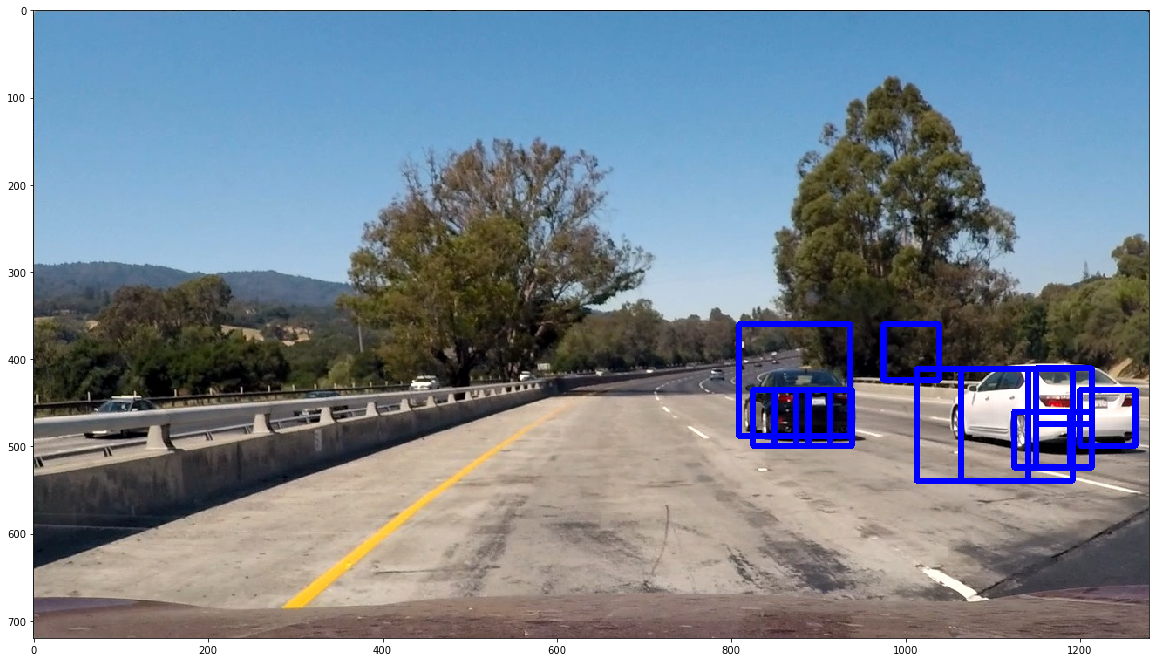

In [27]:
positive_windows = [windows[i] for i in det_inds]
plt.figure(figsize=(20,20))
show_img = draw_boxes(test_img,positive_windows)
plt.imshow(show_img)

In [28]:
# get single shot annotator
out_img,_ = car_finder.get_annotated_image(test_img)

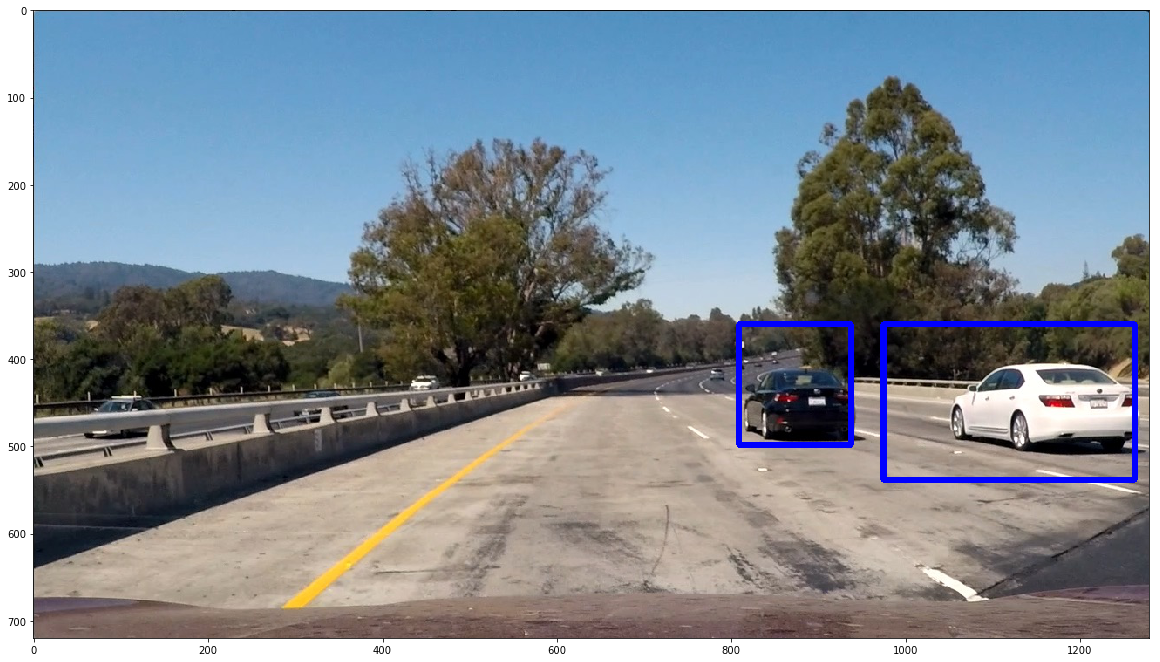

In [29]:
plt.figure(figsize=(20,20))
plt.imshow(out_img)

In [32]:
# Define a method to process video frames
def process_video_frame(img):
    # Use the global Car finder object that we have configured and tested till now
    global car_finder
    
    # set the threshold for the heatmap
    car_finder.threshold = 2
    
    # get the annotated image
    out_img,_ = car_finder.get_annotated_image(img)
    
    # visualize output for debugging
    cv2.imshow('output', out_img)
    cv2.waitKey(10)
    return out_img

In [33]:
proj_out_file = 'project_video_out.mp4'
clip_proj = VideoFileClip('project_video.mp4')
clip_proj_out = clip_proj.fl_image(process_video_frame)
%time clip_proj_out.write_videofile(proj_out_file, audio=False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4



100%|█████████▉| 1260/1261 [16:02<00:00,  1.31it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

CPU times: user 15min 45s, sys: 5.5 s, total: 15min 50s
Wall time: 16min 2s


In [34]:
cv2.destroyAllWindows()
cv2.waitKey(1)

-1